# Marketing Metrics Validation with 2% Threshold

This notebook performs **segment-level validation** for Marketing Metrics data with a **2% tolerance threshold**.

**Files:**
- Target: `growth_team/marketing_metrics_large.csv`
- Gold: `marketing_mertics_large_gold.xlsx`

**Column Mapping:**
- CSV: `Day`, `Campaign name`, `Amount spent (INR)`, `Clicks (all)`, `Impressions`, `Purchases`
- Gold: `date`, `campaign_name`, `spend_cost`, `clicks`, `impressions`, `purchases_conversions`

**Validation Segments:**
- Overall Totals
- By Date
- By Campaign

## Configuration: Set Threshold

In [19]:
# CONFIGURATION: Set your threshold here
THRESHOLD_PERCENT = 2.0  # Accept differences up to 2%

print("="*80)
print("MARKETING METRICS DATA VALIDATION CONFIGURATION")
print("="*80)
print(f"\nThreshold: {THRESHOLD_PERCENT}%")
print(f"Differences under {THRESHOLD_PERCENT}% will be marked as MATCHED")
print("\nYou can change THRESHOLD_PERCENT above to adjust tolerance")

MARKETING METRICS DATA VALIDATION CONFIGURATION

Threshold: 2.0%
Differences under 2.0% will be marked as MATCHED

You can change THRESHOLD_PERCENT above to adjust tolerance


## Step 1: Import Libraries

In [20]:
# Install openpyxl if needed
import sys
!{sys.executable} -m pip install openpyxl -q

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import base64
from io import BytesIO

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ Libraries imported successfully")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported successfully
Analysis started: 2025-12-20 17:53:27


## Step 2: Load and Prepare Data

In [21]:
# Load Target CSV
print("Loading Target CSV...")
growth_df = pd.read_csv("growth_team/fixed_marketing_matrix.csv")

# Clean column names
growth_df.columns = growth_df.columns.str.strip()

# Skip summary row if first row has empty campaign name
if pd.isna(growth_df.iloc[0]['Campaign name']) or str(growth_df.iloc[0]['Campaign name']).strip() == '':
    print("  ✓ Skipping summary row (row 0)")
    growth_df = growth_df.iloc[1:].copy()

print(f"  ✓ Loaded {len(growth_df)} data rows")

# Rename columns to standard names
growth_df.rename(columns={
    'Day': 'Day',
    'Campaign name': 'Campaign name',
    'Amount spent (INR)': 'Cost',
    'Link clicks': 'Clicks',
    'Impressions': 'Impressions',
    'Purchases': 'Purchases'
}, inplace=True)

# Keep required columns only
growth_df = growth_df[['Day', 'Campaign name', 'Cost', 'Clicks', 'Impressions', 'Purchases']]

# Convert Day to standard date string
growth_df['Day'] = pd.to_datetime(growth_df['Day'], format='%d-%m-%Y', errors='coerce')
growth_df = growth_df.dropna(subset=['Day'])
growth_df['Day'] = growth_df['Day'].dt.strftime('%Y-%m-%d')

# 🔑 FIX: Force numeric types (prevents datetime.time sum error)
numeric_cols = ['Cost', 'Clicks', 'Impressions', 'Purchases']
for col in numeric_cols:
    growth_df[col] = pd.to_numeric(growth_df[col], errors='coerce').fillna(0)

# Group by Day + Campaign
print("  ✓ Grouping by Day and Campaign...")
growth_df = growth_df.groupby(['Day', 'Campaign name'], as_index=False).sum()

print(f"✓ Target loaded: {len(growth_df):,} day+campaign combinations")
print(f"  Columns: {growth_df.columns.tolist()}")

# ===============================
# LOAD GOLD EXCEL
# ===============================
print("\nLoading Gold Excel...")
gold_df = pd.read_excel("fixed_marketing_matrix_gold.xlsx")

# Clean column names
gold_df.columns = gold_df.columns.str.strip()
print(f"  ✓ Loaded {len(gold_df)} rows")

# Rename columns
gold_df.rename(columns={
    'date': 'Day',
    'campaign_name': 'Campaign name',
    'spend_cost': 'Cost',
    'clicks': 'Clicks',
    'impressions': 'Impressions',
    'purchases_conversions': 'Purchases'
}, inplace=True)

# Keep required columns only
gold_df = gold_df[['Day', 'Campaign name', 'Cost', 'Clicks', 'Impressions', 'Purchases']]

# Convert Day to standard date string
gold_df['Day'] = pd.to_datetime(gold_df['Day'], errors='coerce')
gold_df = gold_df.dropna(subset=['Day'])
gold_df['Day'] = gold_df['Day'].dt.strftime('%Y-%m-%d')

# 🔑 FIX: Force numeric types (prevents datetime.time sum error)
for col in numeric_cols:
    gold_df[col] = pd.to_numeric(gold_df[col], errors='coerce').fillna(0)

# Group by Day + Campaign
print("  ✓ Grouping by Day and Campaign...")
gold_df = gold_df.groupby(['Day', 'Campaign name'], as_index=False).sum()

print(f"✓ Gold loaded: {len(gold_df):,} day+campaign combinations")
print(f"  Columns: {gold_df.columns.tolist()}")

# ===============================
# SUMMARY
# ===============================
print("\n" + "="*80)
print("DATA SUMMARY")
print("="*80)

print(f"\nTarget Date Range: {growth_df['Day'].min()} to {growth_df['Day'].max()}")
print(f"Gold Date Range: {gold_df['Day'].min()} to {gold_df['Day'].max()}")

print(f"\nTarget Unique Campaigns: {growth_df['Campaign name'].nunique()}")
print(f"Gold Unique Campaigns: {gold_df['Campaign name'].nunique()}")

print(f"\nTarget Day+Campaign combinations: {len(growth_df)}")
print(f"Gold Day+Campaign combinations: {len(gold_df)}")

Loading Target CSV...
  ✓ Loaded 283 data rows
  ✓ Grouping by Day and Campaign...
✓ Target loaded: 282 day+campaign combinations
  Columns: ['Day', 'Campaign name', 'Cost', 'Clicks', 'Impressions', 'Purchases']

Loading Gold Excel...
  ✓ Loaded 1196 rows
  ✓ Grouping by Day and Campaign...
✓ Gold loaded: 282 day+campaign combinations
  Columns: ['Day', 'Campaign name', 'Cost', 'Clicks', 'Impressions', 'Purchases']

DATA SUMMARY

Target Date Range: 2025-11-01 to 2025-12-17
Gold Date Range: 2025-11-01 to 2025-12-17

Target Unique Campaigns: 6
Gold Unique Campaigns: 6

Target Day+Campaign combinations: 282
Gold Day+Campaign combinations: 282


## Step 3: Overall Totals Comparison

In [22]:
print("="*80)
print(f"OVERALL TOTALS COMPARISON (with {THRESHOLD_PERCENT}% threshold)")
print("="*80)

# Calculate totals
growth_totals = growth_df[['Cost', 'Impressions', 'Clicks', 'Purchases']].sum()
gold_totals = gold_df[['Cost', 'Impressions', 'Clicks', 'Purchases']].sum()

# Create comparison dataframe
overall_comparison = pd.DataFrame({
    'Metric': ['Cost', 'Impressions', 'Clicks', 'Purchases'],
    'Target': [growth_totals['Cost'], growth_totals['Impressions'], growth_totals['Clicks'], 
               growth_totals['Purchases']],
    'Gold': [gold_totals['Cost'], gold_totals['Impressions'], gold_totals['Clicks'],
             gold_totals['Purchases']],
})

overall_comparison['Difference'] = overall_comparison['Target'] - overall_comparison['Gold']
overall_comparison['Diff %'] = (overall_comparison['Difference'] / overall_comparison['Gold'] * 100).round(2)
overall_comparison['Match'] = overall_comparison['Diff %'].abs() <= THRESHOLD_PERCENT
overall_comparison['Status'] = overall_comparison['Match'].apply(lambda x: '✓ PASS' if x else '✗ FAIL')

display(overall_comparison)

# Summary
matches = overall_comparison['Match'].sum()
print(f"\n✓ Matches (within {THRESHOLD_PERCENT}%): {matches}/4 metrics")
if matches == 4:
    print(f"✓✓✓ ALL OVERALL TOTALS MATCH (within {THRESHOLD_PERCENT}% threshold)! ✓✓✓")
else:
    print(f"⚠ {4-matches} metric(s) exceed {THRESHOLD_PERCENT}% threshold")

OVERALL TOTALS COMPARISON (with 2.0% threshold)


,Metric,Target,Gold,Difference,Diff %,Match,Status
0,Cost,3830401.13,1702997.40,2127403.73,124.92,False,✗ FAIL
1,Impressions,39479334.00,17224245.00,22255089.00,129.21,False,✗ FAIL
2,Clicks,730899.00,323206.00,407693.00,126.14,False,✗ FAIL
3,Purchases,6040.00,2562.00,3478.00,135.75,False,✗ FAIL



✓ Matches (within 2.0%): 0/4 metrics
⚠ 4 metric(s) exceed 2.0% threshold


## Step 4: Validation by Date

In [23]:
print("="*80)
print(f"SEGMENT VALIDATION: BY DATE (with {THRESHOLD_PERCENT}% threshold)")
print("="*80)

# Aggregate by date
growth_by_date = growth_df.groupby('Day').agg({
    'Cost': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Purchases': 'sum'
}).reset_index()

gold_by_date = gold_df.groupby('Day').agg({
    'Cost': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Purchases': 'sum'
}).reset_index()

# Merge
date_comparison = pd.merge(growth_by_date, gold_by_date, on='Day', 
                           how='outer', suffixes=('_target', '_gold'), indicator=True)

# Fill NaN
for col in ['Cost_target', 'Impressions_target', 'Clicks_target', 'Purchases_target',
            'Cost_gold', 'Impressions_gold', 'Clicks_gold', 'Purchases_gold']:
    date_comparison[col] = date_comparison[col].fillna(0)

# CRITICAL: Convert to float
for col in ['Cost_target', 'Impressions_target', 'Clicks_target', 'Purchases_target',
            'Cost_gold', 'Impressions_gold', 'Clicks_gold', 'Purchases_gold']:
    date_comparison[col] = date_comparison[col].astype(float)

# Safe percentage calculation
def calc_pct_diff(target, gold):
    if abs(float(target) - float(gold)) < 0.01:
        return 0.0
    if gold == 0:
        return 0.0 if target == 0 else 999.0
    return round((target - gold) / gold * 100, 2)

date_comparison['cost_diff_pct'] = date_comparison.apply(
    lambda row: calc_pct_diff(row['Cost_target'], row['Cost_gold']), axis=1)
date_comparison['impr_diff_pct'] = date_comparison.apply(
    lambda row: calc_pct_diff(row['Impressions_target'], row['Impressions_gold']), axis=1)
date_comparison['clicks_diff_pct'] = date_comparison.apply(
    lambda row: calc_pct_diff(row['Clicks_target'], row['Clicks_gold']), axis=1)
date_comparison['purchases_diff_pct'] = date_comparison.apply(
    lambda row: calc_pct_diff(row['Purchases_target'], row['Purchases_gold']), axis=1)

# Validation: Only Cost, Impressions, Clicks
date_comparison['perfect_match'] = (
    (date_comparison['cost_diff_pct'].abs() <= THRESHOLD_PERCENT) & 
    (date_comparison['impr_diff_pct'].abs() <= THRESHOLD_PERCENT) & 
    (date_comparison['clicks_diff_pct'].abs() <= THRESHOLD_PERCENT)
)
date_comparison['status'] = date_comparison['perfect_match'].apply(lambda x: '✓ PASS' if x else '✗ FAIL')

# Add source
date_comparison['source'] = date_comparison['_merge'].map({
    'both': 'Both',
    'left_only': 'Target Only',
    'right_only': 'Gold Only'
})

date_comparison = date_comparison.sort_values('Day')

print(f"\nTotal dates: {len(date_comparison)}")
print(f"  In both files: {(date_comparison['_merge'] == 'both').sum()}")
print(f"  Only in target: {(date_comparison['_merge'] == 'left_only').sum()}")
print(f"  Only in gold: {(date_comparison['_merge'] == 'right_only').sum()}")
print(f"\n✓ Matches (within {THRESHOLD_PERCENT}%): {date_comparison['perfect_match'].sum()}")
print(f"✗ Exceeds threshold: {(~date_comparison['perfect_match']).sum()}")

print("\nDetailed comparison:")
display(date_comparison[['Day', 'source', 'Cost_target', 'Cost_gold', 'cost_diff_pct',
                          'Impressions_target', 'Impressions_gold', 'impr_diff_pct',
                          'Clicks_target', 'Clicks_gold', 'clicks_diff_pct', 'status']])

SEGMENT VALIDATION: BY DATE (with 2.0% threshold)

Total dates: 47
  In both files: 47
  Only in target: 0
  Only in gold: 0

✓ Matches (within 2.0%): 46
✗ Exceeds threshold: 1

Detailed comparison:


,Day,source,Cost_target,Cost_gold,cost_diff_pct,Impressions_target,Impressions_gold,impr_diff_pct,Clicks_target,Clicks_gold,clicks_diff_pct,status
0,2025-11-01,Both,33185.98,33185.98,0.00,625561.00,625561.00,0.00,6000.00,6000.00,0.00,✓ PASS
1,2025-11-02,Both,35206.11,35206.11,0.00,324117.00,324117.00,0.00,5985.00,5985.00,0.00,✓ PASS
2,2025-11-03,Both,30725.85,30725.85,0.00,332202.00,332202.00,0.00,5532.00,5532.00,0.00,✓ PASS
3,2025-11-04,Both,45211.91,45211.91,0.00,570729.00,570729.00,0.00,8701.00,8701.00,0.00,✓ PASS
4,2025-11-05,Both,35116.01,35116.01,0.00,392882.00,392882.00,0.00,7539.00,7539.00,0.00,✓ PASS
5,2025-11-06,Both,34186.02,34186.02,0.00,355815.00,355815.00,0.00,7079.00,7079.00,0.00,✓ PASS
6,2025-11-07,Both,45968.75,45968.75,0.00,478815.00,478815.00,0.00,9474.00,9474.00,0.00,✓ PASS
7,2025-11-08,Both,45073.00,45073.00,0.00,400563.00,400563.00,0.00,7220.00,7220.00,0.00,✓ PASS
8,2025-11-09,Both,45000.79,45000.79,0.00,497160.00,497160.00,0.00,6055.00,6055.00,0.00,✓ PASS
9,2025-11-10,Both,41937.13,41937.13,0.00,431731.00,431731.00,0.00,7477.00,7477.00,0.00,✓ PASS


## Step 5: Validation by Campaign

In [24]:
print("="*80)
print(f"SEGMENT VALIDATION: BY CAMPAIGN (with {THRESHOLD_PERCENT}% threshold)")
print("="*80)

# CRITICAL FIX: Normalize campaign names to ensure matching
# Remove extra spaces, standardize case
growth_df['Campaign name'] = growth_df['Campaign name'].str.strip().str.replace(r'\s+', ' ', regex=True)
gold_df['Campaign name'] = gold_df['Campaign name'].str.strip().str.replace(r'\s+', ' ', regex=True)

# FIX TYPOS: Map common typos to correct names
campaign_name_mapping = {
    'Ikonic ME | Sales Retargetin': 'Ikonic ME | Sales Retargeting',  # Fix missing 'g'
    'Ikonic Professional | Sales Retargetin': 'Ikonic Professional | Sales Retargeting',  # Fix missing 'g'
}

# Apply mapping to both dataframes
growth_df['Campaign name'] = growth_df['Campaign name'].replace(campaign_name_mapping)
gold_df['Campaign name'] = gold_df['Campaign name'].replace(campaign_name_mapping)


print(f"\nUnique campaigns in Target: {growth_df['Campaign name'].nunique()}")
print(f"Unique campaigns in Gold: {gold_df['Campaign name'].nunique()}")

# Aggregate by campaign
growth_by_campaign = growth_df.groupby('Campaign name').agg({
    'Cost': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Purchases': 'sum'
}).reset_index()

gold_by_campaign = gold_df.groupby('Campaign name').agg({
    'Cost': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Purchases': 'sum'
}).reset_index()

# Merge
campaign_comparison = pd.merge(growth_by_campaign, gold_by_campaign, on='Campaign name', 
                               how='outer', suffixes=('_target', '_gold'), indicator=True)

# Fill NaN
for col in ['Cost_target', 'Impressions_target', 'Clicks_target', 'Purchases_target',
            'Cost_gold', 'Impressions_gold', 'Clicks_gold', 'Purchases_gold']:
    campaign_comparison[col] = campaign_comparison[col].fillna(0)

# CRITICAL: Convert to float
for col in ['Cost_target', 'Impressions_target', 'Clicks_target', 'Purchases_target',
            'Cost_gold', 'Impressions_gold', 'Clicks_gold', 'Purchases_gold']:
    campaign_comparison[col] = campaign_comparison[col].astype(float)

# Safe percentage calculation
def calc_pct_diff(target, gold):
    if abs(float(target) - float(gold)) < 0.01:
        return 0.0
    if gold == 0:
        return 0.0 if target == 0 else 999.0
    return round((target - gold) / gold * 100, 2)

campaign_comparison['cost_diff_pct'] = campaign_comparison.apply(
    lambda row: calc_pct_diff(row['Cost_target'], row['Cost_gold']), axis=1)
campaign_comparison['impr_diff_pct'] = campaign_comparison.apply(
    lambda row: calc_pct_diff(row['Impressions_target'], row['Impressions_gold']), axis=1)
campaign_comparison['clicks_diff_pct'] = campaign_comparison.apply(
    lambda row: calc_pct_diff(row['Clicks_target'], row['Clicks_gold']), axis=1)
campaign_comparison['purchases_diff_pct'] = campaign_comparison.apply(
    lambda row: calc_pct_diff(row['Purchases_target'], row['Purchases_gold']), axis=1)

# Validation: Only Cost, Impressions, Clicks
campaign_comparison['perfect_match'] = (
    (campaign_comparison['cost_diff_pct'].abs() <= THRESHOLD_PERCENT) & 
    (campaign_comparison['impr_diff_pct'].abs() <= THRESHOLD_PERCENT) & 
    (campaign_comparison['clicks_diff_pct'].abs() <= THRESHOLD_PERCENT)
)
campaign_comparison['status'] = campaign_comparison['perfect_match'].apply(lambda x: '✓ PASS' if x else '✗ FAIL')

# Add source
campaign_comparison['source'] = campaign_comparison['_merge'].map({
    'both': 'Both',
    'left_only': 'Target Only',
    'right_only': 'Gold Only'
})

print(f"\nTotal campaigns after merge: {len(campaign_comparison)}")
print(f"  In both files: {(campaign_comparison['_merge'] == 'both').sum()}")
print(f"  Only in target: {(campaign_comparison['_merge'] == 'left_only').sum()}")
print(f"  Only in gold: {(campaign_comparison['_merge'] == 'right_only').sum()}")
print(f"\n✓ Matches (within {THRESHOLD_PERCENT}%): {campaign_comparison['perfect_match'].sum()}")
print(f"✗ Exceeds threshold: {(~campaign_comparison['perfect_match']).sum()}")

# Show campaigns only in one file (for debugging)
if (campaign_comparison['_merge'] != 'both').any():
    print("\n⚠️ WARNING: Some campaigns only in one file:")
    mismatched = campaign_comparison[campaign_comparison['_merge'] != 'both'][['Campaign name', 'source']]
    display(mismatched)

print("\nDetailed comparison:")
display(campaign_comparison[['Campaign name', 'source', 'Cost_target', 'Cost_gold', 'cost_diff_pct',
                              'Impressions_target', 'Impressions_gold', 'impr_diff_pct',
                              'Clicks_target', 'Clicks_gold', 'clicks_diff_pct',
                              'Purchases_target', 'Purchases_gold', 'purchases_diff_pct', 'status']].sort_values('Campaign name'))

SEGMENT VALIDATION: BY CAMPAIGN (with 2.0% threshold)

Unique campaigns in Target: 6
Unique campaigns in Gold: 6

Total campaigns after merge: 6
  In both files: 6
  Only in target: 0
  Only in gold: 0

✓ Matches (within 2.0%): 5
✗ Exceeds threshold: 1

Detailed comparison:


,Campaign name,source,Cost_target,Cost_gold,cost_diff_pct,Impressions_target,Impressions_gold,impr_diff_pct,Clicks_target,Clicks_gold,clicks_diff_pct,Purchases_target,Purchases_gold,purchases_diff_pct,status
0,Ikonic ME | Sales Prospecting,Both,250840.50,250845.45,-0.00,2302522.00,2302552.00,-0.00,32443.00,32444.00,-0.00,455.00,342.00,33.04,✓ PASS
1,Ikonic ME | Sales Retargeting,Both,2397736.79,270307.62,787.04,24367783.00,2112405.00,1053.56,437954.00,30255.00,1347.54,3660.00,348.00,951.72,✗ FAIL
2,Ikonic Me | Sales Catalogue,Both,227283.73,227291.81,-0.00,2372121.00,2372197.00,-0.00,50083.00,50087.00,-0.01,472.00,471.00,0.21,✓ PASS
3,Ikonic Professional | Sales Catalogue,Both,241514.62,241519.51,-0.00,2289132.00,2289187.00,-0.00,84139.00,84139.00,0.00,485.00,473.00,2.54,✓ PASS
4,Ikonic Professional | Sales Prospecting,Both,465352.34,465358.50,-0.00,4273587.00,4273673.00,-0.00,75846.00,75847.00,-0.00,678.00,644.00,5.28,✓ PASS
5,Ikonic Professional | Sales Retargeting,Both,247673.15,247674.51,-0.00,3874189.00,3874231.00,-0.00,50434.00,50434.00,0.00,290.00,284.00,2.11,✓ PASS


## Step 6: Final Summary Report

In [25]:
print("="*80)
print(f"MARKETING METRICS VALIDATION SUMMARY (with {THRESHOLD_PERCENT}% threshold)")
print("="*80)
print(f"\nAnalysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Create summary table
summary_data = [
    ['Overall Totals', 4, overall_comparison['Match'].sum(), 4 - overall_comparison['Match'].sum()],
    ['By Date', len(date_comparison), date_comparison['perfect_match'].sum(), 
     (~date_comparison['perfect_match']).sum()],
    ['By Campaign', len(campaign_comparison), campaign_comparison['perfect_match'].sum(), 
     (~campaign_comparison['perfect_match']).sum()]
]

summary_df = pd.DataFrame(summary_data, 
                         columns=['Segment Type', 'Total Segments', 'Matches', 'Exceeds Threshold'])
summary_df['Match %'] = (summary_df['Matches'] / summary_df['Total Segments'] * 100).round(2)

print("\n")
display(summary_df)

# Overall assessment
total_segments = summary_df['Total Segments'].sum()
total_matches = summary_df['Matches'].sum()
overall_match_pct = (total_matches / total_segments * 100)

print("\n" + "="*80)
print(f"OVERALL MATCH RATE (within {THRESHOLD_PERCENT}%): {total_matches}/{total_segments} ({overall_match_pct:.1f}%)")
print("="*80)

if overall_match_pct == 100:
    print(f"\n✓✓✓ PERFECT VALIDATION! All segments within {THRESHOLD_PERCENT}% threshold! ✓✓✓")
elif overall_match_pct >= 95:
    print(f"\n✓ EXCELLENT! {overall_match_pct:.1f}% of segments within {THRESHOLD_PERCENT}% threshold")
elif overall_match_pct >= 80:
    print(f"\n⚠ GOOD: {overall_match_pct:.1f}% within threshold. Some segments need review.")
else:
    print(f"\n⚠ ATTENTION: Only {overall_match_pct:.1f}% within {THRESHOLD_PERCENT}% threshold. Review required.")

print("\n" + "-"*80)
print("KEY INSIGHTS:")
print("-"*80)
print(f"• Threshold used: {THRESHOLD_PERCENT}%")
print(f"• Segments passing: {total_matches}/{total_segments}")
print(f"• Segments exceeding threshold: {total_segments - total_matches}")
print(f"• Target rows: {len(growth_df):,}")
print(f"• Gold rows: {len(gold_df):,}")

print("\n" + "="*80)
print("VALIDATION COMPLETE")
print("="*80)

MARKETING METRICS VALIDATION SUMMARY (with 2.0% threshold)

Analysis completed: 2025-12-20 17:53:28




,Segment Type,Total Segments,Matches,Exceeds Threshold,Match %
0,Overall Totals,4,0,4,0.00
1,By Date,47,46,1,97.87
2,By Campaign,6,5,1,83.33



OVERALL MATCH RATE (within 2.0%): 51/57 (89.5%)

⚠ GOOD: 89.5% within threshold. Some segments need review.

--------------------------------------------------------------------------------
KEY INSIGHTS:
--------------------------------------------------------------------------------
• Threshold used: 2.0%
• Segments passing: 51/57
• Segments exceeding threshold: 6
• Target rows: 282
• Gold rows: 282

VALIDATION COMPLETE


##Step 7: Create Visual Dashboard

CREATING VISUAL DASHBOARD

✓ Dashboard saved as 'meta_validation_dashboard.png'


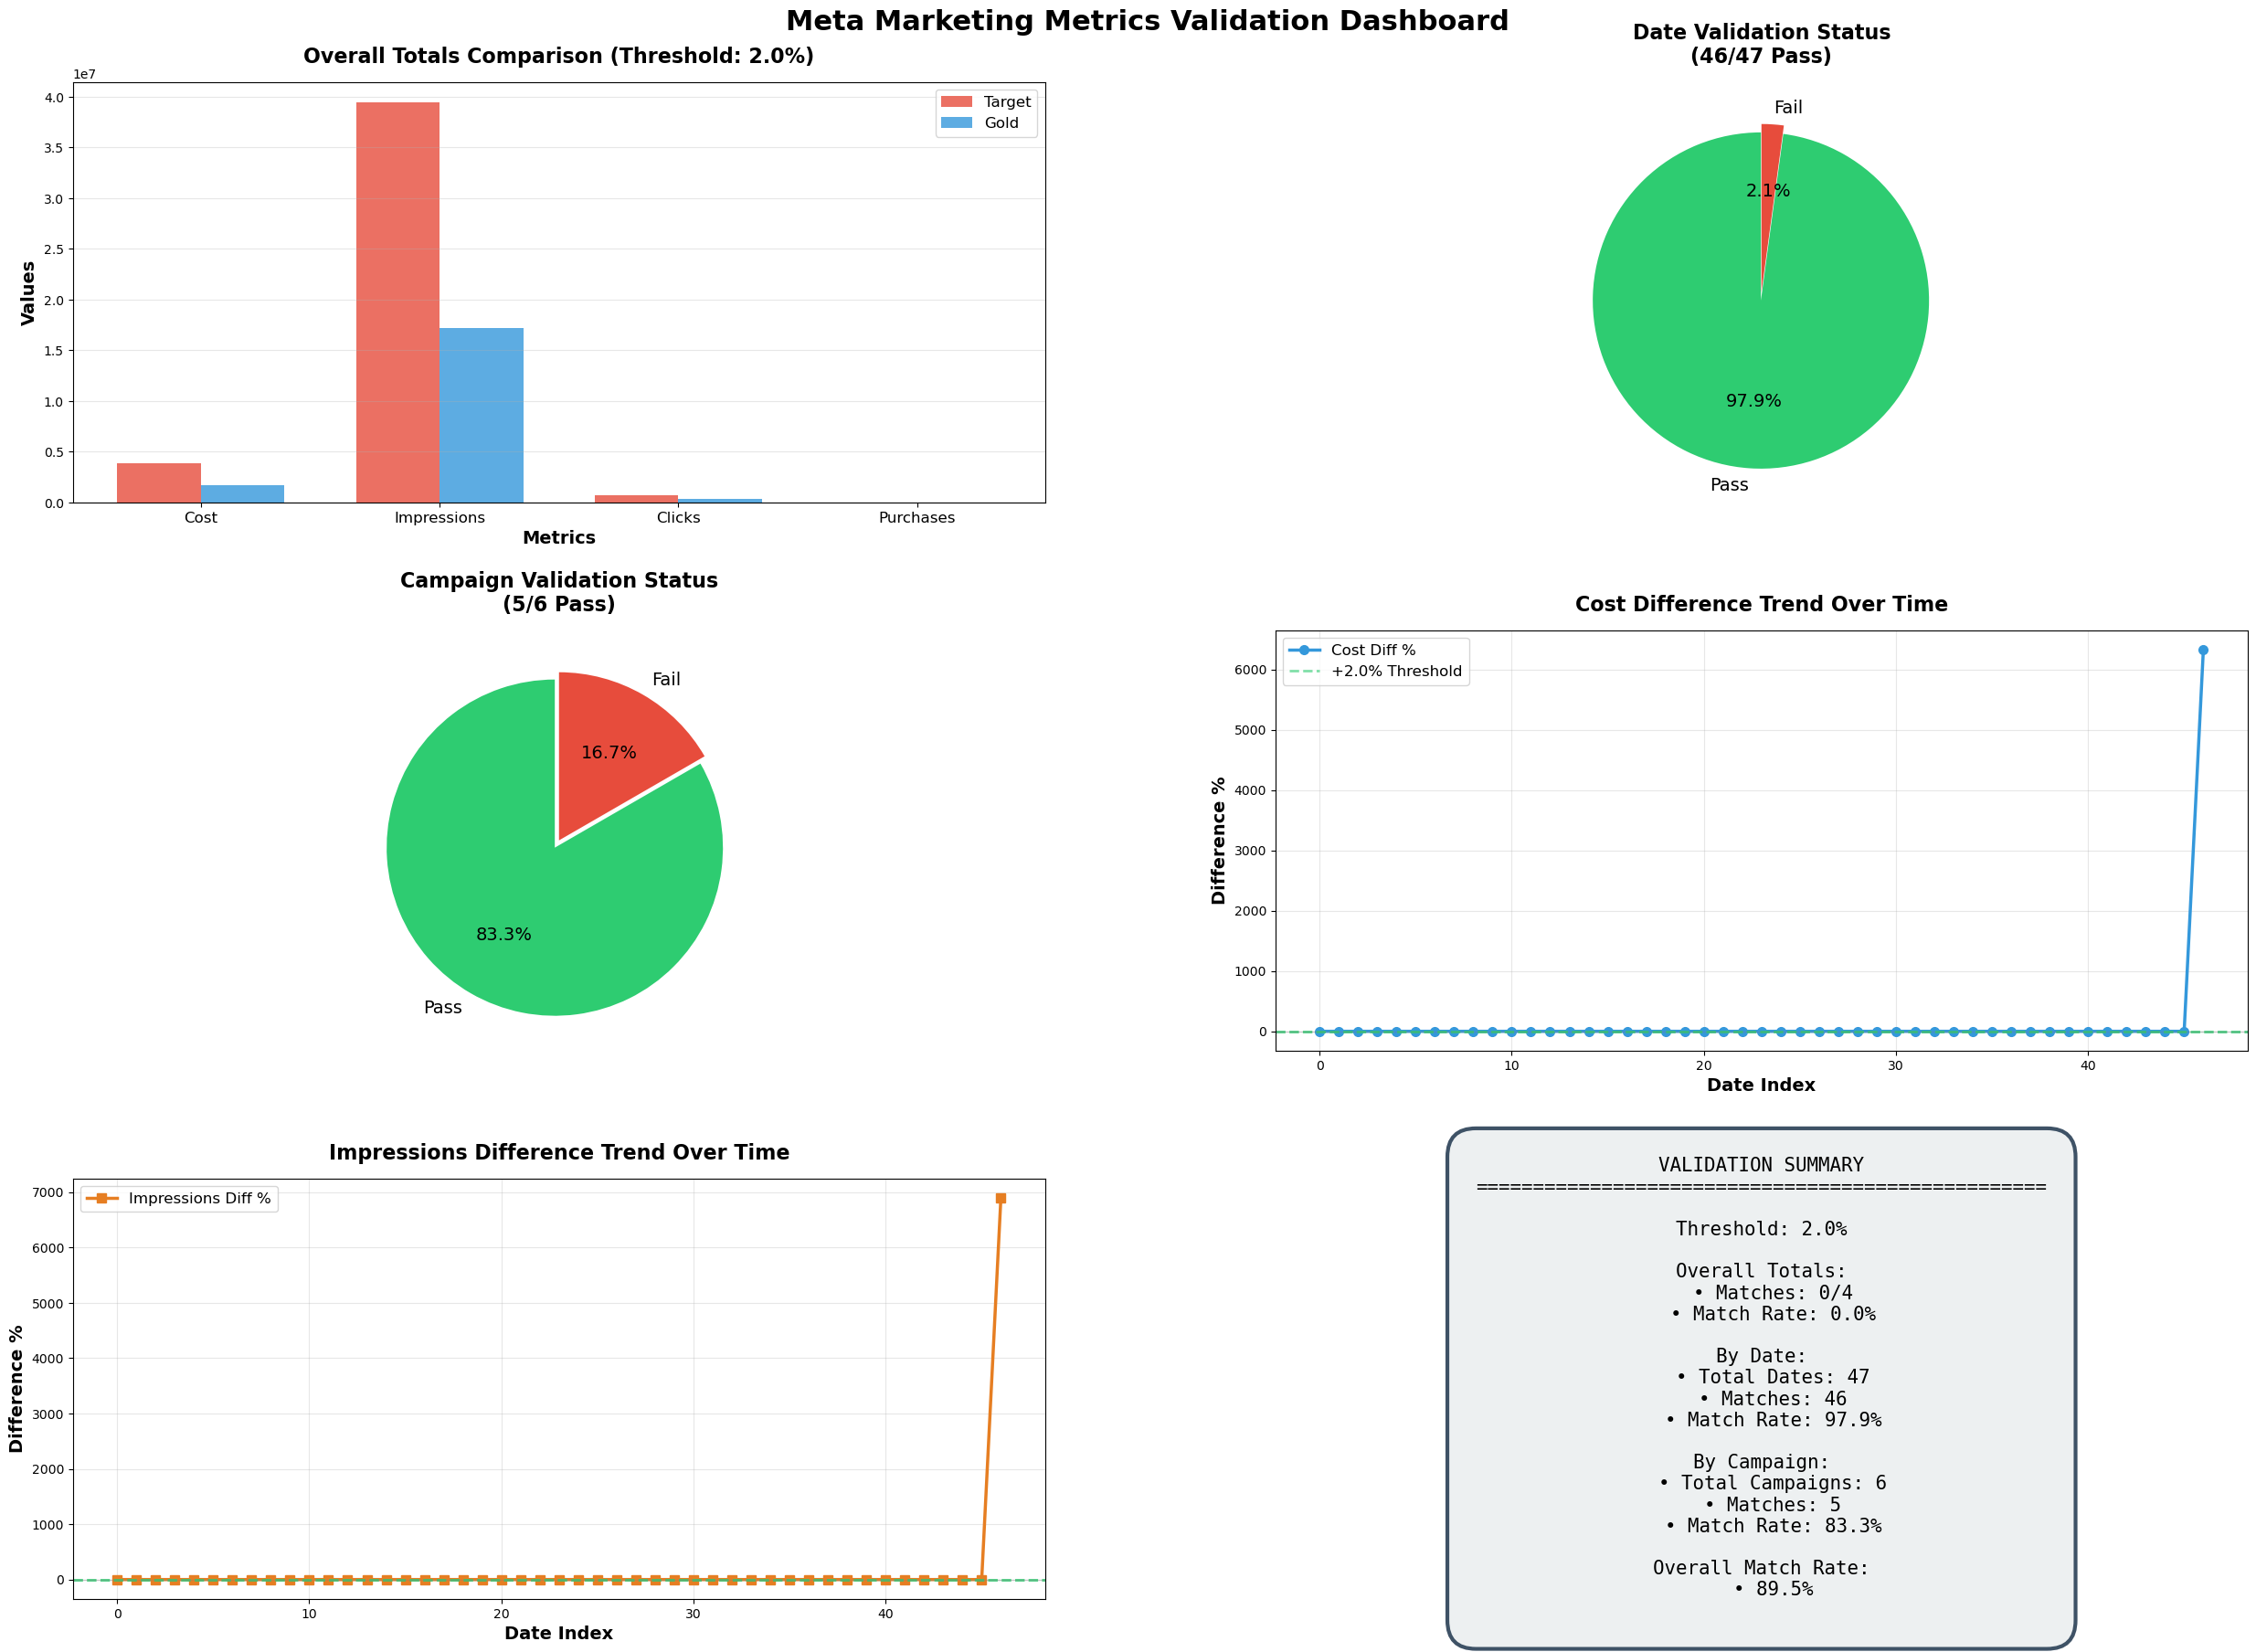


DASHBOARD CREATION COMPLETE


In [26]:
print("="*80)
print("CREATING VISUAL DASHBOARD")
print("="*80)

# Create figure with 6 panels - REDESIGNED WITH PROPER SPACING
fig = plt.figure(figsize=(28, 20))
# Use explicit positioning with guaranteed gaps between panels
# Format: [left, bottom, width, height] in figure coordinates (0-1)

# Row 1: Bar chart and Date pie chart (top row)
ax1 = fig.add_axes([0.08, 0.70, 0.38, 0.23])  # Top left
ax2 = fig.add_axes([0.55, 0.70, 0.38, 0.23])  # Top right

# Row 2: Campaign pie and Cost trend (middle row)
ax3 = fig.add_axes([0.08, 0.40, 0.38, 0.23])  # Middle left
ax4 = fig.add_axes([0.55, 0.40, 0.38, 0.23])  # Middle right

# Row 3: Impressions trend and Summary (bottom row)
ax5 = fig.add_axes([0.08, 0.10, 0.38, 0.23])  # Bottom left
ax6 = fig.add_axes([0.55, 0.10, 0.38, 0.23])  # Bottom right

# Panel 1: Overall Totals Comparison (Bar Chart)
metrics = overall_comparison['Metric'].tolist()
x = range(len(metrics))
width = 0.35

colors_target = ['#2ecc71' if m else '#e74c3c' for m in overall_comparison['Match']]
colors_gold = ['#3498db'] * len(metrics)

ax1.bar([i - width/2 for i in x], overall_comparison['Target'], width, 
        label='Target', color=colors_target, alpha=0.8)
ax1.bar([i + width/2 for i in x], overall_comparison['Gold'], width, 
        label='Gold', color=colors_gold, alpha=0.8)

ax1.set_xlabel('Metrics', fontsize=14, fontweight='bold')
ax1.set_ylabel('Values', fontsize=14, fontweight='bold')
ax1.set_title(f'Overall Totals Comparison (Threshold: {THRESHOLD_PERCENT}%)', 
              fontsize=16, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Panel 2: Date Validation Status (Pie Chart)
date_pass = date_comparison['perfect_match'].sum()
date_fail = (~date_comparison['perfect_match']).sum()

colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)
ax2.pie([date_pass, date_fail], labels=['Pass', 'Fail'], autopct='%1.1f%%',
        colors=colors, explode=explode, startangle=90, textprops={'fontsize': 14})
ax2.set_title(f'Date Validation Status\n({date_pass}/{len(date_comparison)} Pass)', 
              fontsize=16, fontweight='bold', pad=15)

# Panel 3: Campaign Validation Status (Pie Chart)
campaign_pass = campaign_comparison['perfect_match'].sum()
campaign_fail = (~campaign_comparison['perfect_match']).sum()

ax3.pie([campaign_pass, campaign_fail], labels=['Pass', 'Fail'], autopct='%1.1f%%',
        colors=colors, explode=explode, startangle=90, textprops={'fontsize': 14})
ax3.set_title(f'Campaign Validation Status\n({campaign_pass}/{len(campaign_comparison)} Pass)', 
              fontsize=16, fontweight='bold', pad=15)

# Panel 4: Cost Difference Trend (Line Chart)
date_sorted = date_comparison.sort_values('Day')

ax4.plot(range(len(date_sorted)), date_sorted['cost_diff_pct'], 
         marker='o', linewidth=2.5, markersize=7, color='#3498db', label='Cost Diff %')
ax4.axhline(y=THRESHOLD_PERCENT, color='#2ecc71', linestyle='--', 
            linewidth=2, alpha=0.6, label=f'+{THRESHOLD_PERCENT}% Threshold')
ax4.axhline(y=-THRESHOLD_PERCENT, color='#2ecc71', linestyle='--', 
            linewidth=2, alpha=0.6)
ax4.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.3)
ax4.fill_between(range(len(date_sorted)), -THRESHOLD_PERCENT, THRESHOLD_PERCENT, 
                 color='#2ecc71', alpha=0.15)

ax4.set_xlabel('Date Index', fontsize=14, fontweight='bold')
ax4.set_ylabel('Difference %', fontsize=14, fontweight='bold')
ax4.set_title('Cost Difference Trend Over Time', fontsize=16, fontweight='bold', pad=15)
ax4.legend(fontsize=12)
ax4.grid(True, alpha=0.3)

# Panel 5: Impressions Difference Trend (Line Chart)
ax5.plot(range(len(date_sorted)), date_sorted['impr_diff_pct'], 
         marker='s', linewidth=2.5, markersize=7, color='#e67e22', label='Impressions Diff %')
ax5.axhline(y=THRESHOLD_PERCENT, color='#2ecc71', linestyle='--', 
            linewidth=2, alpha=0.6)
ax5.axhline(y=-THRESHOLD_PERCENT, color='#2ecc71', linestyle='--', 
            linewidth=2, alpha=0.6)
ax5.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.3)
ax5.fill_between(range(len(date_sorted)), -THRESHOLD_PERCENT, THRESHOLD_PERCENT, 
                 color='#2ecc71', alpha=0.15)

ax5.set_xlabel('Date Index', fontsize=14, fontweight='bold')
ax5.set_ylabel('Difference %', fontsize=14, fontweight='bold')
ax5.set_title('Impressions Difference Trend Over Time', fontsize=16, fontweight='bold', pad=15)
ax5.legend(fontsize=12)
ax5.grid(True, alpha=0.3)

# Panel 6: Summary Statistics (Text Box)
ax6.axis('off')

summary_text = f'''VALIDATION SUMMARY
{'='*50}

Threshold: {THRESHOLD_PERCENT}%

Overall Totals:
  • Matches: {overall_comparison['Match'].sum()}/4
  • Match Rate: {overall_comparison['Match'].sum()/4*100:.1f}%

By Date:
  • Total Dates: {len(date_comparison)}
  • Matches: {date_pass}
  • Match Rate: {date_pass/len(date_comparison)*100:.1f}%

By Campaign:
  • Total Campaigns: {len(campaign_comparison)}
  • Matches: {campaign_pass}
  • Match Rate: {campaign_pass/len(campaign_comparison)*100:.1f}%

Overall Match Rate:
  • {overall_match_pct:.1f}%
'''

ax6.text(0.5, 0.5, summary_text, fontsize=15, family='monospace',
         verticalalignment='center', horizontalalignment='center',
         bbox=dict(boxstyle='round,pad=1.5', 
         facecolor='#ecf0f1', alpha=0.95, edgecolor='#34495e', linewidth=3),
         transform=ax6.transAxes)

# Add main title
fig.text(0.5, 0.97, 'Meta Marketing Metrics Validation Dashboard', 
         fontsize=22, fontweight='bold', ha='center', va='top')

# Save dashboard
plt.savefig('meta_validation_dashboard.png', dpi=150, bbox_inches='tight', 
            facecolor='white', edgecolor='none', pad_inches=0.3)
print("\n✓ Dashboard saved as 'meta_validation_dashboard.png'")

plt.show()

print("\n" + "="*80)
print("DASHBOARD CREATION COMPLETE")
print("="*80)

## Step 8: Export HTML Report

In [27]:
print("="*80)
print("EXPORTING HTML REPORT")
print("="*80)

# Read the dashboard image and convert to base64
with open('meta_validation_dashboard.png', 'rb') as f:
    img_data = base64.b64encode(f.read()).decode()

# Create HTML report
html_content = f'''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Meta Marketing Metrics Validation Report</title>
    <style>
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 20px;
            min-height: 100vh;
        }}
        .container {{
            max-width: 1400px;
            margin: 0 auto;
            background: white;
            border-radius: 15px;
            box-shadow: 0 20px 60px rgba(0,0,0,0.3);
            overflow: hidden;
        }}
        .header {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 40px;
            text-align: center;
        }}
        .header h1 {{
            font-size: 2.5em;
            margin-bottom: 10px;
            text-shadow: 2px 2px 4px rgba(0,0,0,0.2);
        }}
        .header p {{
            font-size: 1.2em;
            opacity: 0.9;
        }}
        .metrics-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
            gap: 20px;
            padding: 30px;
            background: #f8f9fa;
        }}
        .metric-card {{
            background: white;
            padding: 25px;
            border-radius: 10px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
            text-align: center;
            transition: transform 0.3s ease;
        }}
        .metric-card:hover {{
            transform: translateY(-5px);
            box-shadow: 0 8px 12px rgba(0,0,0,0.15);
        }}
        .metric-card h3 {{
            color: #667eea;
            font-size: 1em;
            margin-bottom: 10px;
            text-transform: uppercase;
            letter-spacing: 1px;
        }}
        .metric-card .value {{
            font-size: 2.5em;
            font-weight: bold;
            color: #2c3e50;
        }}
        .content {{
            padding: 30px;
        }}
        .section {{
            margin-bottom: 40px;
        }}
        .section h2 {{
            color: #667eea;
            font-size: 1.8em;
            margin-bottom: 20px;
            padding-bottom: 10px;
            border-bottom: 3px solid #667eea;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            margin-top: 15px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }}
        th {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 15px;
            text-align: left;
            font-weight: 600;
            text-transform: uppercase;
            font-size: 0.9em;
            letter-spacing: 0.5px;
        }}
        td {{
            padding: 12px 15px;
            border-bottom: 1px solid #ecf0f1;
        }}
        tr:hover {{
            background-color: #f8f9fa;
        }}
        .pass {{
            color: #27ae60;
            font-weight: bold;
        }}
        .fail {{
            color: #e74c3c;
            font-weight: bold;
        }}
        .dashboard-img {{
            width: 100%;
            border-radius: 10px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
            margin: 20px 0;
        }}
        .footer {{
            background: #2c3e50;
            color: white;
            text-align: center;
            padding: 20px;
            font-size: 0.9em;
        }}
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>📊 Meta Marketing Metrics Validation Report</h1>
            <p>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            <p>Threshold: {THRESHOLD_PERCENT}%</p>
        </div>
        
        <div class="metrics-grid">
            <div class="metric-card">
                <h3>Overall Match Rate</h3>
                <div class="value">{overall_match_pct:.1f}%</div>
            </div>
            <div class="metric-card">
                <h3>Dates Matched</h3>
                <div class="value">{date_pass}/{len(date_comparison)}</div>
            </div>
            <div class="metric-card">
                <h3>Campaigns Matched</h3>
                <div class="value">{campaign_pass}/{len(campaign_comparison)}</div>
            </div>
            <div class="metric-card">
                <h3>Threshold</h3>
                <div class="value">±{THRESHOLD_PERCENT}%</div>
            </div>
        </div>
        
        <div class="content">
            <div class="section">
                <h2>📈 Visual Dashboard</h2>
                <img src="data:image/png;base64,{img_data}" class="dashboard-img" alt="Validation Dashboard">
            </div>
            
            <div class="section">
                <h2>📊 Overall Totals Comparison</h2>
                <table>
                    <tr>
                        <th>Metric</th>
                        <th>Target</th>
                        <th>Gold</th>
                        <th>Difference</th>
                        <th>Diff %</th>
                        <th>Status</th>
                    </tr>
'''

for _, row in overall_comparison.iterrows():
    status_class = 'pass' if row['Match'] else 'fail'
    html_content += f'''
                    <tr>
                        <td>{row['Metric']}</td>
                        <td>{row['Target']:,.2f}</td>
                        <td>{row['Gold']:,.2f}</td>
                        <td>{row['Difference']:,.2f}</td>
                        <td>{row['Diff %']:.2f}%</td>
                        <td class="{status_class}">{row['Status']}</td>
                    </tr>
'''

html_content += '''
                </table>
            </div>
            
            <div class="section">
                <h2>📅 Validation by Date (All {len(date_comparison)} Dates)</h2>
                <table>
                    <tr>
                        <th>Date</th>
                        <th>Cost Target</th>
                        <th>Cost Gold</th>
                        <th>Cost Diff %</th>
                        <th>Impressions Target</th>
                        <th>Impressions Gold</th>
                        <th>Impr Diff %</th>
                        <th>Clicks Target</th>
                        <th>Clicks Gold</th>
                        <th>Clicks Diff %</th>
                        <th>Status</th>
                    </tr>
'''

for _, row in date_comparison.sort_values('Day').iterrows():
    status_class = 'pass' if row['perfect_match'] else 'fail'
    html_content += f'''
                    <tr>
                        <td>{row['Day']}</td>
                        <td>{row['Cost_target']:,.2f}</td>
                        <td>{row['Cost_gold']:,.2f}</td>
                        <td>{row['cost_diff_pct']:.2f}%</td>
                        <td>{row['Impressions_target']:,.0f}</td>
                        <td>{row['Impressions_gold']:,.0f}</td>
                        <td>{row['impr_diff_pct']:.2f}%</td>
                        <td>{row['Clicks_target']:,.0f}</td>
                        <td>{row['Clicks_gold']:,.0f}</td>
                        <td>{row['clicks_diff_pct']:.2f}%</td>
                        <td class="{status_class}">{row['status']}</td>
                    </tr>
'''

html_content += '''
                </table>
            </div>
            
            <div class="section">
                <h2>🎯 Validation by Campaign (All {len(campaign_comparison)} Campaigns)</h2>
                <table>
                    <tr>
                        <th>Campaign</th>
                        <th>Source</th>
                        <th>Cost Target</th>
                        <th>Cost Gold</th>
                        <th>Cost Diff %</th>
                        <th>Impressions Target</th>
                        <th>Impressions Gold</th>
                        <th>Impr Diff %</th>
                        <th>Clicks Target</th>
                        <th>Clicks Gold</th>
                        <th>Clicks Diff %</th>
                        <th>Status</th>
                    </tr>
'''

for _, row in campaign_comparison.sort_values('Campaign name').iterrows():
    status_class = 'pass' if row['perfect_match'] else 'fail'
    html_content += f'''
                    <tr>
                        <td>{row['Campaign name']}</td>
                        <td>{row['source']}</td>
                        <td>{row['Cost_target']:,.2f}</td>
                        <td>{row['Cost_gold']:,.2f}</td>
                        <td>{row['cost_diff_pct']:.2f}%</td>
                        <td>{row['Impressions_target']:,.0f}</td>
                        <td>{row['Impressions_gold']:,.0f}</td>
                        <td>{row['impr_diff_pct']:.2f}%</td>
                        <td>{row['Clicks_target']:,.0f}</td>
                        <td>{row['Clicks_gold']:,.0f}</td>
                        <td>{row['clicks_diff_pct']:.2f}%</td>
                        <td class="{status_class}">{row['status']}</td>
                    </tr>
'''

html_content += f'''
                </table>
            </div>
            
            <div class="section">
                <h2>📋 Summary</h2>
                <table>
                    <tr>
                        <th>Segment Type</th>
                        <th>Total Segments</th>
                        <th>Matches</th>
                        <th>Exceeds Threshold</th>
                        <th>Match %</th>
                    </tr>
'''

for _, row in summary_df.iterrows():
    html_content += f'''
                    <tr>
                        <td>{row['Segment Type']}</td>
                        <td>{row['Total Segments']}</td>
                        <td>{row['Matches']}</td>
                        <td>{row['Exceeds Threshold']}</td>
                        <td>{row['Match %']:.2f}%</td>
                    </tr>
'''

html_content += f'''
                </table>
            </div>
        </div>
        
        <div class="footer">
            <p>Meta Marketing Metrics Validation Report | Generated with Python & Pandas</p>
            <p>Threshold: ±{THRESHOLD_PERCENT}% | Overall Match Rate: {overall_match_pct:.1f}%</p>
        </div>
    </div>
</body>
</html>
'''

# Save HTML report
with open('meta_validation_report.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print("\n✓ HTML report saved as 'meta_validation_report.html'")
print("\n" + "="*80)
print("HTML EXPORT COMPLETE")
print("="*80)
print("\nGenerated files:")
print("  • meta_validation_dashboard.png")
print("  • meta_validation_report.html")

# Automatically open HTML report in browser
import webbrowser
import os

html_path = os.path.abspath('meta_validation_report.html')
print(f"\n🌐 Opening report in browser...")
webbrowser.open('file://' + html_path)

print("\n✓ Report opened in your default browser!")
print("\nYou can also manually open 'meta_validation_report.html' anytime.")

EXPORTING HTML REPORT

✓ HTML report saved as 'meta_validation_report.html'

HTML EXPORT COMPLETE

Generated files:
  • meta_validation_dashboard.png
  • meta_validation_report.html

🌐 Opening report in browser...

✓ Report opened in your default browser!

You can also manually open 'meta_validation_report.html' anytime.
